Import Required Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

Load and Parse Data

In [21]:
# Load dataset
df = pd.read_csv("household_power_consumption.txt", sep=';', low_memory=False, na_values='?')

# Combine Date and Time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Sort and set index
df = df.sort_values('Datetime').set_index('Datetime')

# Convert 'Global_active_power' to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop NaNs
df = df[['Global_active_power']].dropna()

# Display sample
df.head()

,Global_active_power
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


Resample to Hourly Data

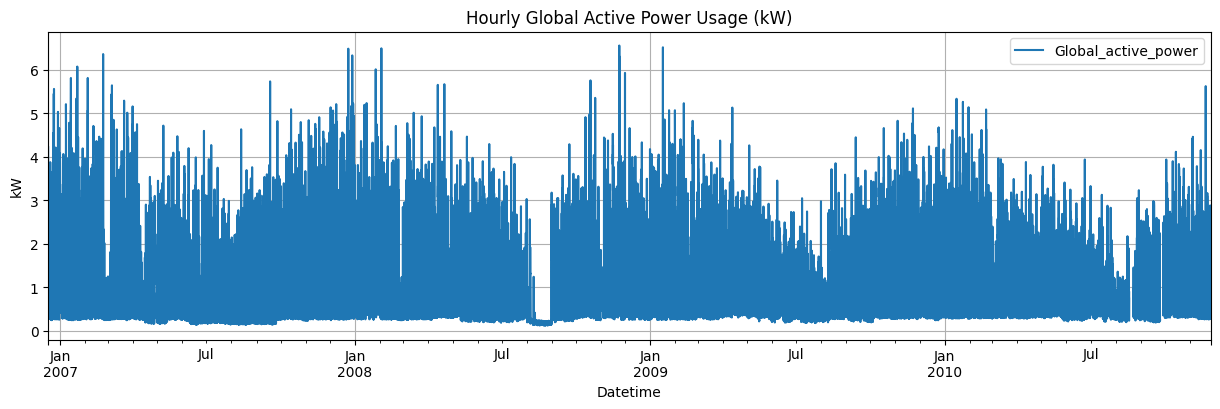

In [22]:
# Hourly average
data = df.resample('H').mean()

# Plot
data.plot(figsize=(15, 4), title='Hourly Global Active Power Usage (kW)')
plt.ylabel('kW')
plt.grid(True)
plt.show()

Feature Engineering

In [23]:
# Add time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

Train-Test Split

In [24]:
# Split last 30 days as test
train = data.iloc[:-24*30]
test = data.iloc[-24*30:]

y_train = train['Global_active_power']
y_test = test['Global_active_power']

ARIMA Model

In [25]:
# Fit ARIMA
model_arima = ARIMA(y_train, order=(3,1,2))
model_arima_fit = model_arima.fit()

# Forecast
forecast_arima = model_arima_fit.forecast(steps=len(y_test))

# Evaluation
mae_arima = mean_absolute_error(y_test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(y_test, forecast_arima))

Prophet Model

In [26]:
# Prepare data
prophet_df = y_train.reset_index()
prophet_df.columns = ['ds', 'y']

# Fit model
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_df)

# Future dataframe
future = model_prophet.make_future_dataframe(periods=len(y_test), freq='H')

# Forecast
forecast_prophet = model_prophet.predict(future)
forecast_values = forecast_prophet.set_index('ds')['yhat'][-len(y_test):]

# Evaluation
mae_prophet = mean_absolute_error(y_test, forecast_values)
rmse_prophet = np.sqrt(mean_squared_error(y_test, forecast_values))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ov4dsju/qk76y5ka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ov4dsju/qwgnakf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2848', 'data', 'file=/tmp/tmp6ov4dsju/qk76y5ka.json', 'init=/tmp/tmp6ov4dsju/qwgnakf3.json', 'output', 'file=/tmp/tmp6ov4dsju/prophet_modelwawi9m38/prophet_model-20250707115511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:55:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


XGBoost Model

In [27]:
# Prepare features
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['lag1'] = df['Global_active_power'].shift(1)
    df['lag24'] = df['Global_active_power'].shift(24)
    return df

train_feat = create_features(train).dropna()
test_feat = create_features(test)

X_train = train_feat.drop('Global_active_power', axis=1)
y_train_xgb = train_feat['Global_active_power']

X_test = test_feat.drop('Global_active_power', axis=1)
y_test_xgb = test_feat['Global_active_power']

# Fit XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train_xgb)

# Predict
forecast_xgb = model_xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test_xgb, forecast_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, forecast_xgb))

Compare Results

In [28]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [mae_arima, mae_prophet, mae_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_xgb]
})
print(results)

     Model       MAE      RMSE
0    ARIMA  0.669927  0.829697
1  Prophet  0.563392  0.728328
2  XGBoost  0.376205  0.548930


Visualization

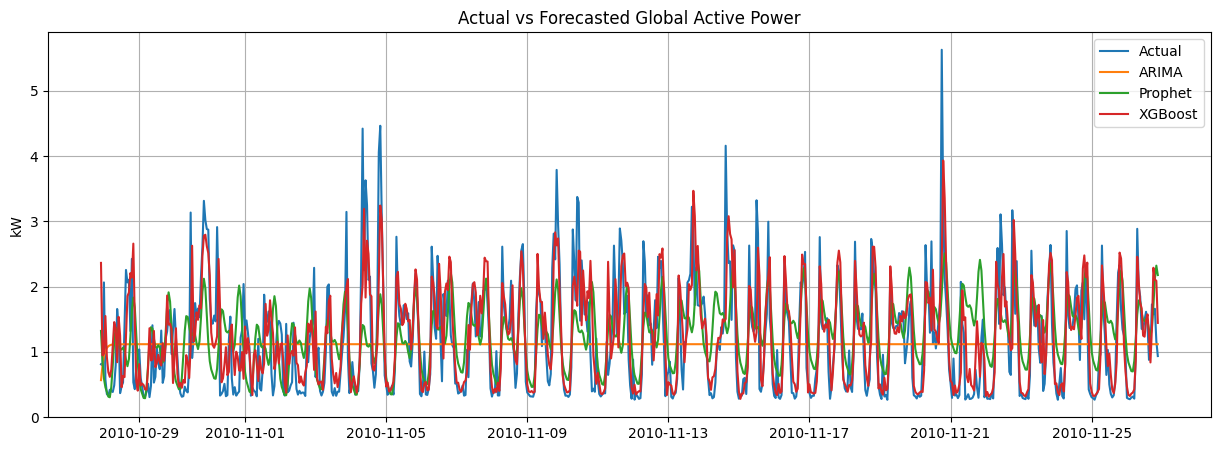

In [29]:
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, forecast_arima.values, label='ARIMA')
plt.plot(y_test.index, forecast_values.values, label='Prophet')
plt.plot(y_test.index, forecast_xgb, label='XGBoost')
plt.legend()
plt.title('Actual vs Forecasted Global Active Power')
plt.ylabel('kW')
plt.grid(True)
plt.show()